# Emotion recognition- RAVDESS dataset

In [399]:
# https://sail.usc.edu/iemocap/

### MFCCS- mel- frequency cepstrum coefficients

### Computing the cepstrum:

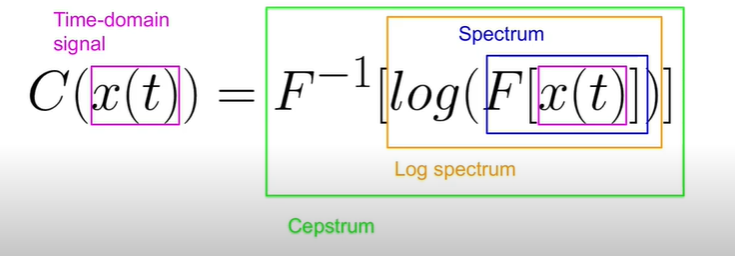

### We're basically trasforming our sound wave to an absolute formation, then create a log which allows us to see the signal's Frequency VS it's Magnitude and allows us to examine periodicities and general trend as well. Lastly were performing an inverse transformation which results in a general spectrum of the signal (Quefrency VS Magnitude).

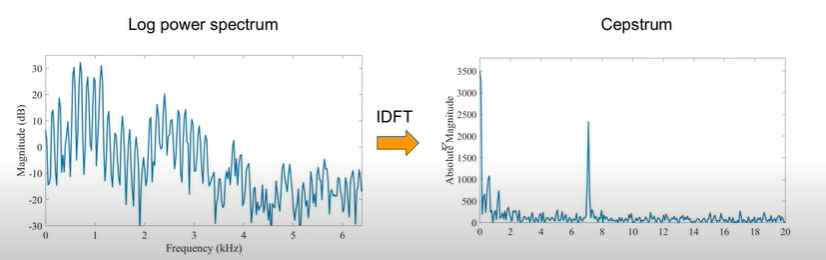

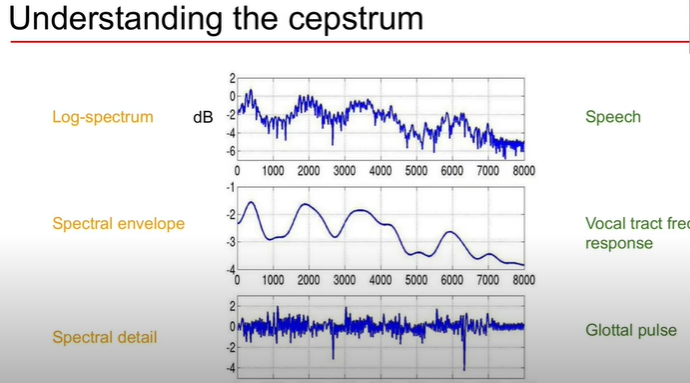

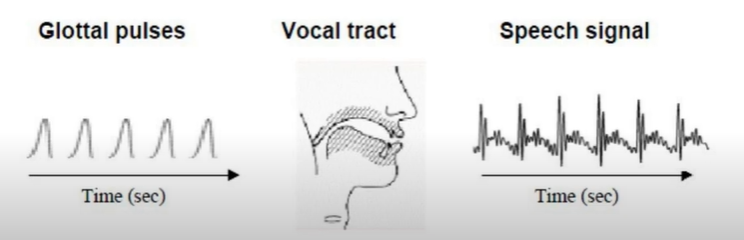

### Speech = Convolution of vocal tract frequency response and Glottal pulse.

### We are mostly interested in the Vocal tract, which contains the main knowledge that helps us understand our data (formants), and therefore we're looking for a way to seperate the Vocal tract from the Speech wave without having the Glottal pulse as well. We do that by applying a logarithm on the amplitude (audio is perceived logarithmically and not linearly), mel-scaling, and then a transformation (Discrete cosine transform).

### Our result- the waves coefficients! (MFCCS)

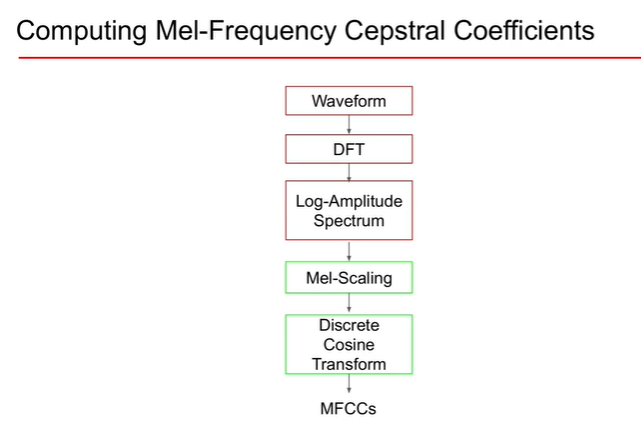

### Sources:

- https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/CNN_ASLPTrans2-14.pdf


### RAVDESS- File Summary

#### In total, the RAVDESS collection includes 7356 files (2880+2024+1440+1012 files).

#### File naming convention

##### Each of the 7356 RAVDESS files has a unique filename. The filename consists of a 7-part numerical identifier (e.g., 02-01-06-01-02-01-12.mp4). These identifiers define the stimulus characteristics: 

#### Filename identifiers 

* Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
* Vocal channel (01 = speech, 02 = song).
* Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
* Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
* Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
* Repetition (01 = 1st repetition, 02 = 2nd repetition).
* Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

  Filename example: 02-01-06-01-02-01-12.mp4 

* Video-only (02)
* Speech (01)
* Fearful (06)
* Normal intensity (01)
* Statement "dogs" (02)
* 1st Repetition (01)
* 12th Actor (12)
* Female, as the actor ID number is even.

## Import libraries

In [3]:
import os
import librosa
import numpy as np
from tqdm.notebook import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
sns.set_style('whitegrid')
import IPython.display as ipd
import librosa.display
import numpy as np
import cv2
import pickle

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, confusion_matrix
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

from tqdm.notebook import tqdm

import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Conv2D, AveragePooling1D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

# from livelossplot import PlotLossesKeras
tf.config.list_physical_devices('GPU')

[]

### Extract data from folder, and get our MFCC's for future classification:

## Get data:

### (Using the combined DF, MFCC's and column 'emotion2' as target)

In [2]:
import pickle

df_path = 'd://ITC//final_project//combined.csv'
# mfccs_path = 'd://itc//final_project//mfccs.pickle'
# new_y_path = 'd://itc//final_project//y.pickle'

# with open('d://downloads//y.pickle', 'wb') as f:
#     pickle.dump(new_y, f)
    
# with open('d://downloads//mfccs.pickle', 'wb') as f:
#     pickle.dump(mfccs, f)

mydf = pd.read_csv(df_path)

# with open(mfccs_path, 'rb') as f:
#     mfccs = pickle.load(f)

# with open(new_y_path, 'rb') as f:
#     new_y = pickle.load(f)

### Create DF from MFCC's and 'emotion2' columns as labels

In [3]:
new_y = mydf['emotion2'].copy()

In [4]:
X = []
for i in tqdm(mydf['path']):
    X.append(librosa.load(i, res_type='kaiser_fast', sr=44000))

  0%|          | 0/4720 [00:00<?, ?it/s]

In [5]:
new_x = []
for ind,i in enumerate(X):
    new_x.append(i[0])

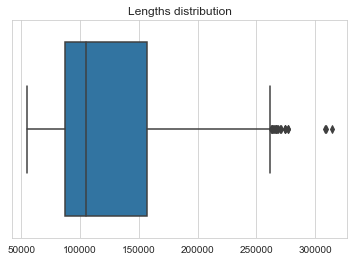

In [6]:
lengths = [len(x) for x in new_x]

plt.title('Lengths distribution')
sns.boxplot(lengths)
plt.show()

In [7]:
thresh = 300000

3


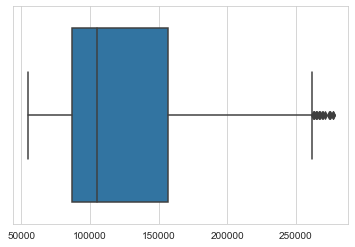

In [8]:
lengths = np.array(lengths)
print((lengths > thresh).sum())
new_lengths = lengths[lengths < thresh]

sns.boxplot(new_lengths)
plt.show()

In [9]:
new_lengths.mean()

120378.5976256095

In [10]:
length_chosen = 120378

In [11]:
import math

X_new = []
y_new = []
for ind,i in enumerate(new_x):
    if i.shape[0] < 300000:
        if i.shape[0] > length_chosen:
            new = i[:length_chosen]
            X_new.append(new)
        elif i.shape[0] < length_chosen:
            new = np.pad(i,math.ceil((length_chosen-i.shape[0])/2), mode='median')
            X_new.append(new)
        else:
            X_new.append(i)
            
        y_new.append(new_y[ind])
            

In [12]:
X = np.array(X_new)
y = np.array(y_new)
print(X.shape, y.shape)

(4717,) (4717,)


<ipython-input-12-c6c504f55594>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  X = np.array(X_new)


In [13]:
mfccs = []
for i in tqdm(X):
    mfcc = librosa.feature.mfcc(y=i, sr=44000, n_mfcc=20)
    mfcc = mfcc.T
    mfccs.append(mfcc)


  0%|          | 0/4717 [00:00<?, ?it/s]

In [14]:
mfccs = np.array(mfccs)

In [15]:
mydf.shape, mfccs.shape, y.shape

((4720, 6), (4717, 236, 20), (4717,))

### Save the data:

In [16]:
mfccs_path = 'd://ITC//final_project//mfccs.pickle'
y_path = 'd://ITC//final_project//y.pickle'

with open(mfccs_path, 'wb') as f:
    pickle.dump(mfccs,f)
    
with open(y_path, 'wb') as f:
    pickle.dump(y,f)

# BASELINE MODEL

### At this point, we can perform a normal classification, using our mfccs coefficients as our features.

In [2]:
# random:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(mfccs, y, test_size=0.20)
X_train.shape, X_test.shape, y_train.shape, y_test.shape


### We'll change the values in our target variable and expand the dimension of our features to fit the neural networks.

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense

model = Sequential(
    [
     layers.Conv1D(64, 3, activation='relu', input_shape=(236,20)),
     layers.MaxPooling1D(),
     layers.Conv1D(64, 3, activation='relu'),
     layers.MaxPooling1D(),
     layers.Conv1D(64, 3, activation='relu'),
     layers.MaxPooling1D(),
     layers.Flatten(),
     layers.Dense(64, activation="relu"),
     layers.Dense(6, activation="softmax")
    ]
)


In [95]:
model.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_90 (Conv1D)           (None, 234, 64)           3904      
_________________________________________________________________
max_pooling1d_40 (MaxPooling (None, 117, 64)           0         
_________________________________________________________________
conv1d_91 (Conv1D)           (None, 115, 64)           12352     
_________________________________________________________________
max_pooling1d_41 (MaxPooling (None, 57, 64)            0         
_________________________________________________________________
conv1d_92 (Conv1D)           (None, 55, 64)            12352     
_________________________________________________________________
max_pooling1d_42 (MaxPooling (None, 27, 64)            0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 1728)            

In [96]:
model.input_shape, model.output_shape

((None, 236, 20), (None, 6))

### Encoding the labels:

In [19]:
set(y)

{'negative_female',
 'negative_male',
 'neutral_female',
 'neutral_male',
 'positive_female',
 'positive_male'}

In [20]:
emotions_encode = {'negative_female':0, 'negative_male':1, 'neutral_female':2, 'neutral_male':3,
                  'positive_female':4, 'positive_male':5}

In [21]:
y_train = pd.Series(y_train).map(emotions_encode)
y_test = pd.Series(y_test).map(emotions_encode)

In [99]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics='accuracy')
model.fit(X_train, y_train, batch_size=16, epochs=50, validation_data=(X_test, y_test))

Epoch 1/50
236/236 [==============================] - 20s 13ms/step - loss: 5.8538 - accuracy: 0.4724 - val_loss: 0.6819 - val_accuracy: 0.7066
Epoch 2/50
236/236 [==============================] - 2s 10ms/step - loss: 0.5316 - accuracy: 0.7633 - val_loss: 0.4354 - val_accuracy: 0.7977
Epoch 3/50
236/236 [==============================] - 2s 10ms/step - loss: 0.4226 - accuracy: 0.8040 - val_loss: 0.4130 - val_accuracy: 0.8030
Epoch 4/50
236/236 [==============================] - 2s 10ms/step - loss: 0.3744 - accuracy: 0.8267 - val_loss: 0.4577 - val_accuracy: 0.7977
Epoch 5/50
236/236 [==============================] - 2s 10ms/step - loss: 0.3433 - accuracy: 0.8393 - val_loss: 0.3599 - val_accuracy: 0.8263
Epoch 6/50
236/236 [==============================] - 2s 10ms/step - loss: 0.2857 - accuracy: 0.8825 - val_loss: 0.4165 - val_accuracy: 0.8189
Epoch 7/50
236/236 [==============================] - 2s 10ms/step - loss: 0.3498 - accuracy: 0.8473 - val_loss: 0.3270 - val_accuracy: 0.861

In [29]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)
y_pred = [np.argmax(x) for x in y_pred]
print(classification_report(y_test, y_pred, target_names = list(emotions_encode.keys())))

In [72]:
mydf['emotion2'].unique()

array(['negative_female', 'positive_female', 'neutral_female',
       'neutral_male', 'positive_male', 'negative_male'], dtype=object)

In [22]:
import tensorflow as tf

model2 = Sequential()

model2.add(layers.Conv1D(256, 5,padding='same',
                 input_shape=(236,20)))
model2.add(layers.Activation('relu'))
model2.add(layers.MaxPooling1D(pool_size=(8)))
model2.add(layers.Dropout(0.1))

model2.add(layers.Conv1D(128, 5,padding='same'))
model2.add(layers.Activation('relu'))
model2.add(layers.Dropout(0.1))

model2.add(layers.Flatten())
model2.add(layers.Dense(6))
model2.add(layers.Activation('softmax'))

model2.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 236, 256)          25856     
_________________________________________________________________
activation (Activation)      (None, 236, 256)          0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 29, 256)           0         
_________________________________________________________________
dropout (Dropout)            (None, 29, 256)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 29, 128)           163968    
_________________________________________________________________
activation_1 (Activation)    (None, 29, 128)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 29, 128)           0

In [16]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', 
                                                 factor=0.5, patience=4, 
                                                 verbose=1, mode='max', 
                                                 min_lr=0.00001)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=40, 
                                              verbose=1)

weight_path = 'd://ITC//final_project//best_weights.hdf5'
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=weight_path, 
                                                      save_weights_only=True, 
                                                      monitor='val_accuracy', 
                                                      mode='max', 
                                                      save_best_only=True)


In [31]:
model2.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics='accuracy')
model2.fit(X_train, y_train, batch_size=16, epochs=500, validation_data=(X_test, y_test),
           callbacks=[reduce_lr, early_stop, model_checkpoint])

Epoch 1/500
236/236 [==============================] - 6s 25ms/step - loss: 0.0031 - accuracy: 0.9989 - val_loss: 0.7180 - val_accuracy: 0.8972
Epoch 2/500
236/236 [==============================] - 6s 24ms/step - loss: 0.0041 - accuracy: 0.9984 - val_loss: 0.7073 - val_accuracy: 0.8941
Epoch 3/500
236/236 [==============================] - 6s 24ms/step - loss: 0.0095 - accuracy: 0.9979 - val_loss: 0.7165 - val_accuracy: 0.8941
Epoch 4/500
236/236 [==============================] - 6s 24ms/step - loss: 0.0054 - accuracy: 0.9979 - val_loss: 0.7106 - val_accuracy: 0.8909
Epoch 5/500
236/236 [==============================] - 6s 25ms/step - loss: 0.0034 - accuracy: 0.9987 - val_loss: 0.7105 - val_accuracy: 0.8919
Epoch 6/500
236/236 [==============================] - 6s 24ms/step - loss: 0.0030 - accuracy: 0.9992 - val_loss: 0.7163 - val_accuracy: 0.8909
Epoch 7/500
236/236 [==============================] - 6s 25ms/step - loss: 0.0047 - accuracy: 0.9979 - val_loss: 0.7203 - val_accuracy:

KeyboardInterrupt: 

In [32]:
model2.load_weights('d://ITC//final_project//best_weights.hdf5')

In [33]:
y_pred = model2.predict(X_test)
y_pred = [np.argmax(x) for x in y_pred]
print(classification_report(y_test, y_pred, target_names = list(emotions_encode.keys())))

                 precision    recall  f1-score   support

negative_female       0.96      0.98      0.97       396
  negative_male       0.73      0.74      0.74       138
 neutral_female       0.99      0.94      0.97       104
   neutral_male       0.80      0.77      0.79        57
positive_female       0.97      0.97      0.97       190
  positive_male       0.59      0.58      0.58        59

       accuracy                           0.90       944
      macro avg       0.84      0.83      0.83       944
   weighted avg       0.90      0.90      0.90       944



## Classifiy emotions- first we'll need to create new MFCC's and target arrays:

In [34]:
mydf['emotion3'].unique()

array(['fear_female', 'surprise_female', 'sad_female', 'negative_female',
       'positive_female', 'neutral_female', 'neutral_male',
       'positive_male', 'sad_male', 'negative_male', 'fear_male',
       'surprise_male'], dtype=object)

In [35]:
mydf['emotion3'].replace(['fear_female', 'fear_male'], 'fear', inplace=True)
mydf['emotion3'].replace(['surprise_female', 'surprise_male'], 'surprise', inplace=True)
mydf['emotion3'].replace(['sad_female', 'sad_male'], 'sadness', inplace=True)
mydf['emotion3'].replace(['negative_female', 'negative_male'], 'negetive', inplace=True)
mydf['emotion3'].replace(['positive_female', 'positive_male'], 'positive', inplace=True)
mydf['emotion3'].replace(['neutral_female', 'neutral_male'], 'neutral', inplace=True)

In [36]:
mydf['emotion3'].unique()

array(['fear', 'surprise', 'sadness', 'negetive', 'positive', 'neutral'],
      dtype=object)

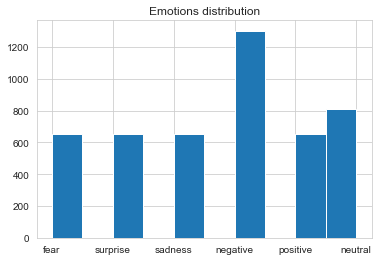

In [689]:
plt.title('Emotions distribution')
# plt.hist(mydf['emotion3'])
plt.hist(y)
plt.show()

In [51]:
y = mydf['emotion3'].copy()

In [52]:
y.shape

(4720,)

In [53]:
X = []
for i in tqdm(mydf['path']):
    X.append(librosa.load(i, res_type='kaiser_fast', sr=44000))

  0%|          | 0/4720 [00:00<?, ?it/s]

In [55]:
new_x = []
for ind,i in enumerate(X):
    new_x.append(i[0])

In [56]:
lengths = [len(x) for x in new_x]

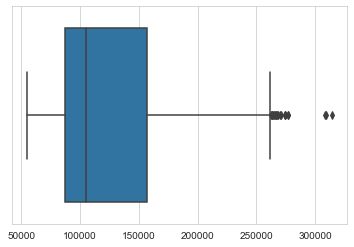

In [57]:
sns.boxplot(lengths)
plt.show()

3


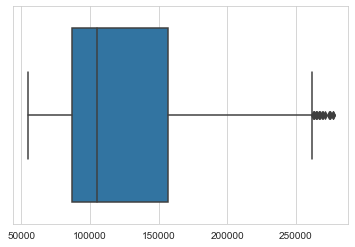

In [58]:
lengths = np.array(lengths)
print((lengths > 300000).sum())
new_lengths = lengths[lengths < 300000]

sns.boxplot(new_lengths)
plt.show()

In [59]:
print(new_lengths.mean())

120378.5976256095


In [60]:
length_chosen = 120378

In [61]:
import math

X_new = []
y_new = []
for ind,i in enumerate(new_x):
    if i.shape[0] < 300000:
        if i.shape[0] > length_chosen:
            new = i[:length_chosen]
            X_new.append(new)
        elif i.shape[0] < length_chosen:
            new = np.pad(i,math.ceil((length_chosen-i.shape[0])/2), mode='median')
            X_new.append(new)
        else:
            X_new.append(i)
            
        y_new.append(y[ind])
            

In [62]:
X = np.array(X_new)
y = np.array(y_new)
print(X.shape, y.shape)

(4717,) (4717,)


<ipython-input-62-c6c504f55594>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  X = np.array(X_new)


In [63]:
mfccs = []
for i in tqdm(X):
    mfcc = librosa.feature.mfcc(y=i, sr=44000, n_mfcc=40)
    mfcc = mfcc.T
    mfccs.append(mfcc)


  0%|          | 0/4717 [00:00<?, ?it/s]

In [64]:
mfccs = np.array(mfccs)
mfccs.shape

(4717, 236, 40)

In [73]:
set(y)

{'fear', 'negetive', 'neutral', 'positive', 'sadness', 'surprise'}

### Save new data:

In [255]:
import pickle 

mfccs2_path = 'd://ITC//final_project_data//mfccs2.pickle'
y2_path = 'd://ITC//final_project_data//y2.pickle'

# with open(mfccs2_path, 'wb') as f:
#     pickle.dump(mfccs,f)
    
# with open(y2_path, 'wb') as f:
#     pickle.dump(y,f)
    
with open(mfccs2_path, 'rb') as f:
    mfccs = pickle.load(f)
    
with open(y2_path, 'rb') as f:
    y = pickle.load(f)

In [256]:
set(y)

{'fear', 'negetive', 'neutral', 'positive', 'sadness', 'surprise'}

In [257]:
y = np.where(y == 'negetive', 'negative', y)

In [258]:
set(y)

{'fear', 'negative', 'neutral', 'positive', 'sadness', 'surprise'}

In [259]:
emotion_enc = {'fear':0, 'negative':1, 'neutral':2, 'positive':3, 'sadness':4, 'surprise':5}

In [260]:
X_train, X_val, y_train, y_val = train_test_split(mfccs, y, test_size=0.2, random_state=12)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=15)

X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((3773, 236, 40), (472, 236, 40), (472, 236, 40), (3773,), (472,), (472,))

In [261]:
y_train = pd.Series(y_train).map(emotion_enc)
y_val = pd.Series(y_val).map(emotion_enc)
y_test = pd.Series(y_test).map(emotion_enc)

In [262]:
y_train.unique(), y_test.unique(), y_val.unique()

(array([1, 0, 3, 2, 4, 5], dtype=int64),
 array([2, 3, 0, 1, 4, 5], dtype=int64),
 array([5, 3, 0, 1, 4, 2], dtype=int64))

In [263]:
# X_train = np.moveaxis(X_train,1,-1)
# X_val = np.moveaxis(X_val,1,-1)
# X_test = np.moveaxis(X_test,1,-1)

In [265]:
model3 = Sequential()

model3.add(layers.Conv1D(256, 5,padding='same',
                 input_shape=(236,40)))
model3.add(layers.Activation('relu'))
model3.add(layers.MaxPooling1D(pool_size=(8)))
model3.add(layers.Dropout(0.2))

model3.add(layers.Conv1D(128, 5,padding='same'))
model3.add(layers.Activation('relu'))
model3.add(layers.MaxPooling1D(pool_size=(4)))
model3.add(layers.Dropout(0.1))

model3.add(layers.Flatten())
model3.add(layers.Dense(64))
model3.add(layers.Dense(6))
model3.add(layers.Activation('softmax'))

model3.summary()


Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_33 (Conv1D)           (None, 236, 256)          51456     
_________________________________________________________________
activation_49 (Activation)   (None, 236, 256)          0         
_________________________________________________________________
max_pooling1d_33 (MaxPooling (None, 29, 256)           0         
_________________________________________________________________
dropout_33 (Dropout)         (None, 29, 256)           0         
_________________________________________________________________
conv1d_34 (Conv1D)           (None, 29, 128)           163968    
_________________________________________________________________
activation_50 (Activation)   (None, 29, 128)           0         
_________________________________________________________________
max_pooling1d_34 (MaxPooling (None, 7, 128)          

In [266]:
# weight_path2 = 'd://ITC//final_project_data//best_weights3.hdf5'
weight_path2 = 'd://ITC//final_project_data//best_weights4.hdf5'

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', 
                                                 factor=0.5, patience=4, 
                                                 verbose=1, mode='max', 
                                                 min_lr=0.00001)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=40, 
                                              verbose=1)

model_checkpoint2 = tf.keras.callbacks.ModelCheckpoint(filepath=weight_path2, 
                                                      save_weights_only=True, 
                                                      monitor='val_accuracy', 
                                                      mode='max', 
                                                      save_best_only=True)


In [267]:
model3.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics='accuracy')
model3.fit(X_train, y_train, batch_size=16, epochs=500, validation_data=(X_val, y_val),
           callbacks=[reduce_lr, early_stop, model_checkpoint2])

Epoch 1/500
236/236 [==============================] - 6s 25ms/step - loss: 26.5869 - accuracy: 0.3130 - val_loss: 1.0602 - val_accuracy: 0.5826
Epoch 2/500
236/236 [==============================] - 6s 26ms/step - loss: 1.0783 - accuracy: 0.5850 - val_loss: 0.7496 - val_accuracy: 0.6949
Epoch 3/500
236/236 [==============================] - 5s 22ms/step - loss: 0.8525 - accuracy: 0.6559 - val_loss: 0.7333 - val_accuracy: 0.6949
Epoch 4/500
236/236 [==============================] - 5s 20ms/step - loss: 0.7557 - accuracy: 0.7028 - val_loss: 0.7048 - val_accuracy: 0.7076
Epoch 5/500
236/236 [==============================] - 5s 20ms/step - loss: 0.7610 - accuracy: 0.7113 - val_loss: 0.6893 - val_accuracy: 0.7246
Epoch 6/500
236/236 [==============================] - 5s 20ms/step - loss: 0.7136 - accuracy: 0.7214 - val_loss: 0.7289 - val_accuracy: 0.7055
Epoch 7/500
236/236 [==============================] - 5s 19ms/step - loss: 0.6653 - accuracy: 0.7327 - val_loss: 0.6827 - val_accuracy

In [268]:
model3.load_weights(weight_path2)

## Transfer learning

In [269]:
# pretrained_model = tf.keras.applications.DenseNet201(include_top=False, 
#                                                      weights='imagenet', 
#                                                      input_shape=(236,40,3))
# # pretrained_model.trainable = False
# for layer in pretrained_model.layers:
#   if 'conv5' in layer.name:
#     layer.trainable = True
#   else:
#     layer.trainable = False

# pretrained_model.input_shape, pretrained_model.output_shape

In [270]:
# X_train.shape

In [271]:
# X_train_expand = np.expand_dims(X_train, 3)
# X_test_expand = np.expand_dims(X_test, 3)

In [28]:
# X_train_expand.shape, X_test_expand.shape

In [27]:
# before_model = Sequential()

# before_model.add(layers.Conv1D(256, 5,padding='same',
#                  input_shape=(236,40,1)))
# before_model.add(layers.Activation('relu'))
# before_model.add(layers.Dropout(0.2))
# # before_model.add(layers.UpSampling2D(size=2))
# before_model.add(layers.Dense(64))
# before_model.add(layers.Dense(3))

# before_model.summary()

In [26]:
# after_model = tf.keras.models.Sequential()
# after_model.add(before_model)
# after_model.add(pretrained_model)
# after_model.add(tf.keras.layers.GlobalAveragePooling2D())
# after_model.add(tf.keras.layers.Flatten())

# after_model.add(tf.keras.layers.Dense(256))
# after_model.add(tf.keras.layers.Dropout(0.2))

# after_model.add(tf.keras.layers.Dense(128))
# after_model.add(tf.keras.layers.Dropout(0.1))
# after_model.add(tf.keras.layers.Dense(6, activation='softmax'))

# after_model.summary()

In [25]:
# after_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics='accuracy')
# after_model.fit(X_train_expand, y_train, batch_size=32, epochs=500, validation_data=(X_test_expand, y_test),
#            callbacks=[reduce_lr, early_stop, model_checkpoint2])

### Final evaluation:

In [272]:
def report_res_and_plot_matrix(y_test, y_pred, plot_classes):

  #report metrics
  acc = accuracy_score(y_test, y_pred)
  print(f"Accuracy: {acc:.4f}")
  # print(f"Classes: {plot_classes}")

  #plot matrix
  cnf_matrix = confusion_matrix(y_test, y_pred)
  fig, ax = plt.subplots()
    
  tick_marks = np.arange(len(plot_classes))
  plt.xticks(ticks=tick_marks, labels=plot_classes, rotation=90)
  plt.yticks(ticks=tick_marks, labels=plot_classes, rotation=90)

  group_counts = [f'{value:0.0f}' for value in cnf_matrix.flatten()]
  group_percentages = [f'{100 * value:0.1f} %' for value in 
                       cnf_matrix.flatten()/np.sum(cnf_matrix)]
  labels = [f'{v1}\n({v2})' for v1, v2 in
            zip(group_counts,group_percentages)]
  n = int(np.sqrt(len(labels)))
  labels = np.asarray(labels).reshape(n,n)
  sns.heatmap(cnf_matrix, annot=labels, fmt='', cmap='Blues',
              xticklabels=plot_classes, yticklabels=plot_classes)


  ax.xaxis.set_label_position("bottom")
  plt.tight_layout()
  plt.title('Confusion matrix', y=1.1)
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')
  plt.show()

  # return metrics
  return [acc, cnf_matrix]

              precision    recall  f1-score   support

        fear       0.85      0.83      0.84        75
    negative       0.87      0.89      0.88       125
     neutral       0.84      0.92      0.88        76
    positive       0.86      0.90      0.88        60
     sadness       0.83      0.81      0.82        67
    surprise       0.95      0.84      0.89        69

    accuracy                           0.87       472
   macro avg       0.87      0.86      0.86       472
weighted avg       0.87      0.87      0.87       472

Accuracy: 0.8665


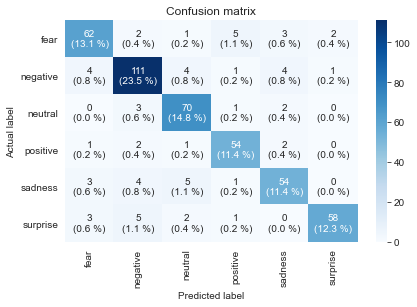

In [277]:
from sklearn.metrics import classification_report

y_pred = model3.predict(X_test).argmax(axis=1)

print(classification_report(y_test, y_pred, target_names=list(emotion_enc.keys())))
params = report_res_and_plot_matrix(y_test, y_pred, list(emotion_enc.keys()))

### Visualization of our classes

In [75]:
X_test.shape, X_train.shape, y_pred.shape

((472, 236, 40), (3773, 236, 40), (472,))

In [76]:
X_test_new = X_test.reshape(472,-1).copy()
X_train_new = X_train.reshape(3773,-1).copy()

In [77]:
X_test_new.shape, X_train_new.shape

((472, 9440), (3773, 9440))

In [78]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = StandardScaler()
scaler.fit(X_train_new)
X_train_scaled = scaler.transform(X_train_new)
X_test_scaled = scaler.transform(X_test_new)


In [79]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit_transform(X_train_scaled)
X_pca = pca.transform(X_test_scaled)


In [80]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=6, random_state=0).fit(X_pca)
labels = kmeans.labels_

In [81]:
set(labels)

{0, 1, 2, 3, 4, 5}

### Figuring out which label resambles which class:

emotion_enc = {'fear':0, 'negative':1, 'neutral':2, 'positive':3, 'sadness':4, 'surprise':5}

In [82]:
set(y_pred)

{0, 1, 2, 3, 4, 5}

In [83]:
l = pd.get_dummies(labels)
p = pd.get_dummies(y_pred)

l.shape, p.shape

((472, 6), (472, 6))

In [84]:
h = pd.merge(l, p, left_index=True, right_index=True)

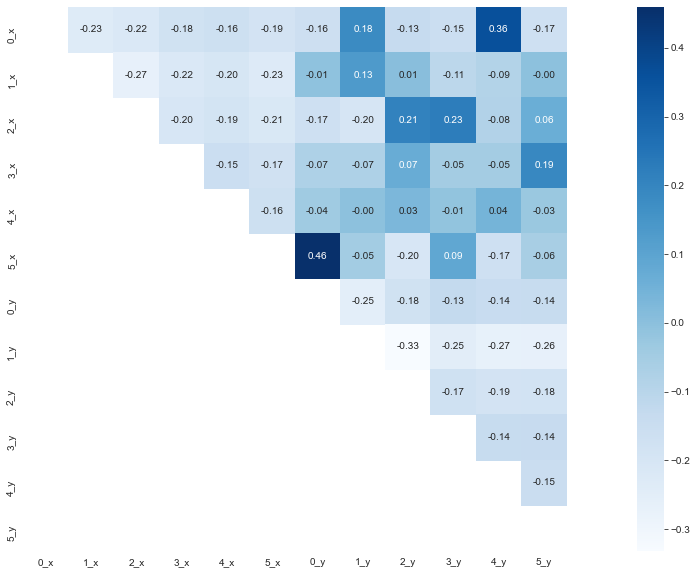

In [85]:
corr = h.corr(method='spearman')
mask = np.tril(np.ones_like(corr, dtype=np.bool))
ax = plt.figure(figsize=(25,10))
ax = sns.heatmap(h.corr(method='spearman'), annot=True, fmt=".2f", mask = mask, square = True, cmap="Blues")

In [86]:
a = pd.DataFrame(labels)
b = pd.DataFrame(y_pred)
c = pd.DataFrame()
c['labels'] = a[0].copy()
c['y_pred'] = b[0].copy()

In [87]:
c.head()

,labels,y_pred
0,5,0
1,0,1
2,0,4
3,5,5
4,1,2


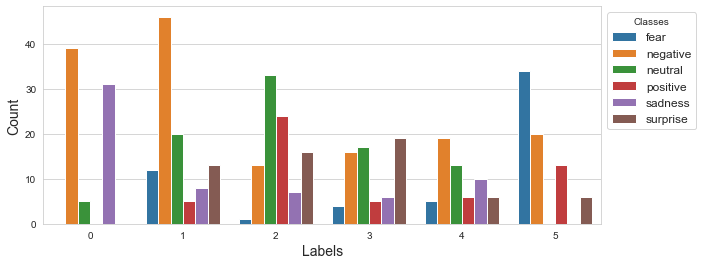

In [88]:
plt.figure(figsize=(10,4))
sns.countplot(x='labels', hue="y_pred", data=c)
plt.xlabel('Labels', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.legend(title='Classes', bbox_to_anchor = (1,1), labels=list(emotion_enc.keys()), fontsize='large')
plt.show()

### Corresponding classes:

- label 0 - class 4
- label 1 - class 1
- label 2 - class 2
- label 3 - class 5
- label 4 - class 3
- label 5 - class 0


emotion_enc = {'fear':0, 'negative':1, 'neutral':2, 'positive':3, 'sadness':4, 'surprise':5}

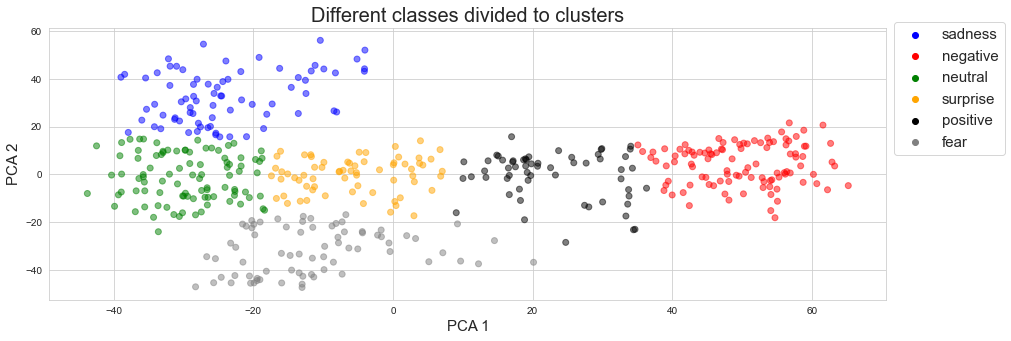

In [91]:
colors = {0:'blue', 1:'red', 2:'green', 3:'orange', 4:'black', 5:'grey'}
lab = ['sadness', 'negative', 'neutral', 'surprise', 'positive', 'fear']


fig = plt.figure(figsize = (15, 5))
ax = fig.add_subplot(111)
ax.scatter(X_pca[:, 0], X_pca[:, 1], c = pd.Series(labels).map(colors), alpha=0.5)
for i in range(6):
    plt.scatter(None, None, color=colors[i], label=lab[i])

plt.title('Different classes divided to clusters', fontsize=20)
plt.legend(fontsize=15, bbox_to_anchor= [1, 1.05])
plt.xlabel('PCA 1', fontsize=15)
plt.ylabel('PCA 2', fontsize=15)
plt.show()

### Save models:

In [276]:
import tensorflow as tf

# model2.save('d://ITC//final_project_data//model2.h5')
# model3.save('d://ITC//final_project_data//model3.h5')

model3 = tf.keras.models.load_model('d://ITC//final_project_data//model3.h5')

#### add confusion matrix- 
https://deeplizard.com/learn/video/km7pxKy4UHU

#### add dendogram